In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Rescaling, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam, Adamax
from keras.metrics import categorical_crossentropy
from keras import regularizers
from keras.models import Model
from keras import backend as K
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
from IPython.display import YouTubeVideo


In [3]:
# Load the dataset
file_path = '/content/drive/MyDrive/ToddlerAutismdataset.csv'
df = pd.read_csv(file_path)

# Display the columns to check their exact names
print("Original Column Names:")
print(df.columns)

# Strip any leading or trailing whitespace characters from column names
df.columns = df.columns.str.strip()

# Display the columns again to confirm the changes
print("Cleaned Column Names:")
print(df.columns)


Original Column Names:
Index(['Case_No', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10',
       'Age_Mons', 'Qchat-10-Score', 'Sex', 'Ethnicity', 'Jaundice',
       'Family_mem_with_ASD', 'Who completed the test', 'Class/ASD Traits '],
      dtype='object')
Cleaned Column Names:
Index(['Case_No', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10',
       'Age_Mons', 'Qchat-10-Score', 'Sex', 'Ethnicity', 'Jaundice',
       'Family_mem_with_ASD', 'Who completed the test', 'Class/ASD Traits'],
      dtype='object')


In [4]:
# Display the first few rows of the dataset
df.head()


,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Qchat-10-Score,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who completed the test,Class/ASD Traits
0,1,0,0,0,0,0,0,1,1,0,1,28,3,f,middle eastern,yes,no,family member,No
1,2,1,1,0,0,0,1,1,0,0,0,36,4,m,White European,yes,no,family member,Yes
2,3,1,0,0,0,0,0,1,1,0,1,36,4,m,middle eastern,yes,no,family member,Yes
3,4,1,1,1,1,1,1,1,1,1,1,24,10,m,Hispanic,no,no,family member,Yes
4,5,1,1,0,1,1,1,1,1,1,1,20,9,f,White European,no,yes,family member,Yes


In [5]:
# Calculating the percentage of babies showing symptoms of autism
# Use the correct column name
if 'Class/ASD Traits' in df.columns:
    yes_autism = df[df['Class/ASD Traits'].str.strip().str.lower() == 'yes']
    no_autism = df[df['Class/ASD Traits'].str.strip().str.lower() == 'no']

    print("Toddlers with Autism:", round(len(yes_autism) / len(df) * 100, 2))
    print("Toddlers without Autism:", round(len(no_autism) / len(df) * 100, 2))
else:
    print("'Class/ASD Traits' column not found in the DataFrame.")


Toddlers with Autism: 69.07
Toddlers without Autism: 30.93


In [6]:
# Dropping unnecessary columns
df = df.drop(['Sex', 'Jaundice', 'Family_mem_with_ASD', 'Who completed the test', 'Ethnicity'], axis=1)

# Splitting features and labels
df_features = df.iloc[:, :-1]
df_labels = df.iloc[:, [-1]]

# Convert 'Class/ASD Traits' to binary labels
df_labels = df_labels['Class/ASD Traits'].str.strip().str.lower().map({'yes': 1, 'no': 0})

# Converting DataFrame to numpy arrays
tab_features = df_features.to_numpy()
labels = df_labels.to_numpy()


In [7]:
# Path to images
img_dir = '/content/drive/MyDrive/images/images'

# Image dimensions
img_height = 64
img_width = 64


In [8]:
# Reading and resizing images
files = os.listdir(img_dir)
files.sort(key=lambda x: int(x.split('.')[0]))

img_list = []
for file in files:
    img = cv2.imread(os.path.join(img_dir, file))
    img = cv2.resize(img, (img_height, img_width))
    img_list.append(img)

img_features = np.asarray(img_list)


In [9]:
# Shuffling the data
rng = np.random.default_rng(seed=14)
size = len(tab_features)
p = rng.permutation(size)
tab_features = tab_features[p]
img_features = img_features[p]
labels = labels[p]

# Splitting the dataset
val_idx = int(size * 0.6)
test_idx = int(size * 0.8)

X_tab_train, X_tab_val, X_tab_test = np.split(tab_features, [val_idx, test_idx])
X_img_train, X_img_val, X_img_test = np.split(img_features, [val_idx, test_idx])
y_train, y_val, y_test = np.split(labels, [val_idx, test_idx])

# Building the tabular data model
input_tab = Input(shape=(X_tab_train.shape[1],))
x_tab = Dense(1024, activation='relu')(input_tab)
x_tab = Dense(1024, activation='relu')(x_tab)
model_tab = Model(input_tab, x_tab)


In [10]:
# Building the image data model
input_img = Input(shape=(img_height, img_width, 3))
x_img = Rescaling(1./255)(input_img)
x_img = Conv2D(64, 3, padding='same', activation='relu')(x_img)
x_img = Conv2D(64, 3, padding='same', activation='relu')(x_img)
x_img = MaxPooling2D(padding='same')(x_img)
x_img = BatchNormalization()(x_img)
x_img = Conv2D(128, 3, padding='same', activation='relu')(x_img)
x_img = Conv2D(128, 3, padding='same', activation='relu')(x_img)
x_img = MaxPooling2D(padding='same')(x_img)
x_img = BatchNormalization()(x_img)
x_img = Conv2D(256, 3, padding='same', activation='relu')(x_img)
x_img = Conv2D(256, 3, padding='same', activation='relu')(x_img)
x_img = Conv2D(256, 3, padding='same', activation='relu')(x_img)
x_img = MaxPooling2D(padding='same')(x_img)
x_img = BatchNormalization()(x_img)
x_img = Conv2D(512, 3, padding='same', activation='relu')(x_img)
x_img = Conv2D(512, 3, padding='same', activation='relu')(x_img)
x_img = Conv2D(512, 3, padding='same', activation='relu')(x_img)
x_img = MaxPooling2D(padding='same')(x_img)
x_img = BatchNormalization()(x_img)
x_img = Conv2D(1024, 3, padding='same', activation='relu')(x_img)
x_img = Conv2D(1024, 3, padding='same', activation='relu')(x_img)
x_img = Conv2D(1024, 3, padding='same', activation='relu')(x_img)
x_img = MaxPooling2D(padding='same')(x_img)
x_img = BatchNormalization()(x_img)
x_img = Dropout(0.25)(x_img)
x_img = Flatten()(x_img)
x_img = Dense(1024, activation='relu')(x_img)
x_img = Dense(1024, activation='relu')(x_img)
model_img = Model(input_img, x_img)


In [11]:
# Custom F1 score function
def F1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

# Concatenate tabular and image models
input_combined = Concatenate()([model_tab.output, model_img.output])
x = Dense(1024, activation='relu')(input_combined)
x = Dropout(0.1)(x)
x = Dense(1024, activation='relu')(x)
x = Dense(2, activation='softmax')(x)


In [12]:
# Create the final model
model = Model([model_tab.input, model_img.input], x)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy', F1_score])

# Model summary
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 64, 64, 3)            0         ['input_2[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           1792      ['rescaling[0][0]']           
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           36928     ['conv2d[0][0]']              
                                                                                            

In [13]:
# Training parameters
epochs = 100
batch_size = 64
early_stopping = EarlyStopping(patience=10, verbose=2, restore_best_weights=True)


In [14]:
# Train the model
history = model.fit(
    [X_tab_train, X_img_train],
    y_train,
    validation_data=([X_tab_val, X_img_val], y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]
)


Epoch 1/100
10/10 [==============================] - 30s 1s/step - loss: 20.6665 - accuracy: 0.5839 - F1_score: 0.8155 - val_loss: 289.9082 - val_accuracy: 0.3318 - val_F1_score: 0.7620
Epoch 2/100
10/10 [==============================] - 2s 172ms/step - loss: 3.2558 - accuracy: 0.5491 - F1_score: 0.8165 - val_loss: 2.9989 - val_accuracy: 0.6682 - val_F1_score: 0.7620
Epoch 3/100
10/10 [==============================] - 2s 157ms/step - loss: 1.1922 - accuracy: 0.5839 - F1_score: 0.8150 - val_loss: 3.3676 - val_accuracy: 0.6682 - val_F1_score: 0.7620
Epoch 4/100
10/10 [==============================] - 2s 158ms/step - loss: 0.7147 - accuracy: 0.6519 - F1_score: 0.8148 - val_loss: 0.6561 - val_accuracy: 0.6682 - val_F1_score: 0.7620
Epoch 5/100
10/10 [==============================] - 2s 161ms/step - loss: 0.6244 - accuracy: 0.6915 - F1_score: 0.8150 - val_loss: 0.6185 - val_accuracy: 0.6682 - val_F1_score: 0.7620
Epoch 6/100
10/10 [==============================] - 2s 160ms/step - loss:

In [15]:
# Learning curves for training and validation
history_df = pd.DataFrame(history.history)
print(history_df)

         loss  accuracy  F1_score    val_loss  val_accuracy  val_F1_score
0   20.666481  0.583861  0.815537  289.908173      0.331754      0.761977
1    3.255793  0.549051  0.816475    2.998925      0.668246      0.761977
2    1.192181  0.583861  0.814950    3.367615      0.668246      0.761977
3    0.714735  0.651899  0.814848    0.656115      0.668246      0.761977
4    0.624393  0.691456  0.814962    0.618521      0.668246      0.761977
5    0.624331  0.685127  0.814851    0.601202      0.668246      0.761977
6    0.577795  0.708861  0.814984    0.551486      0.668246      0.761977
7    0.500142  0.761076  0.814991    0.477809      0.701422      0.761977
8    0.384803  0.832278  0.814711    0.383428      0.748815      0.761977
9    0.349563  0.822785  0.815475    0.412144      0.748815      0.761977
10   0.288133  0.857595  0.814712    0.196703      0.928910      0.761977
11   0.277898  0.857595  0.815028    0.244123      0.838863      0.761977
12   0.281166  0.878165  0.814224    0

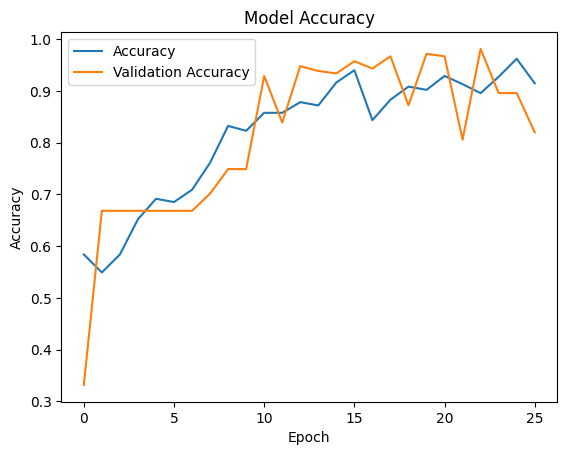

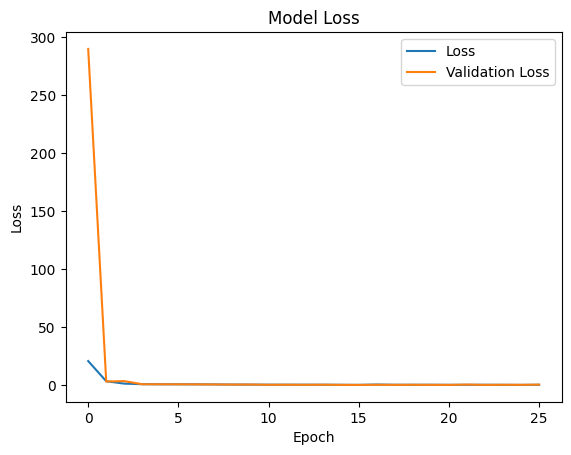

In [16]:
# Plotting overall accuracy
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Text(0.5, 1.0, 'Training and Validation Loss')

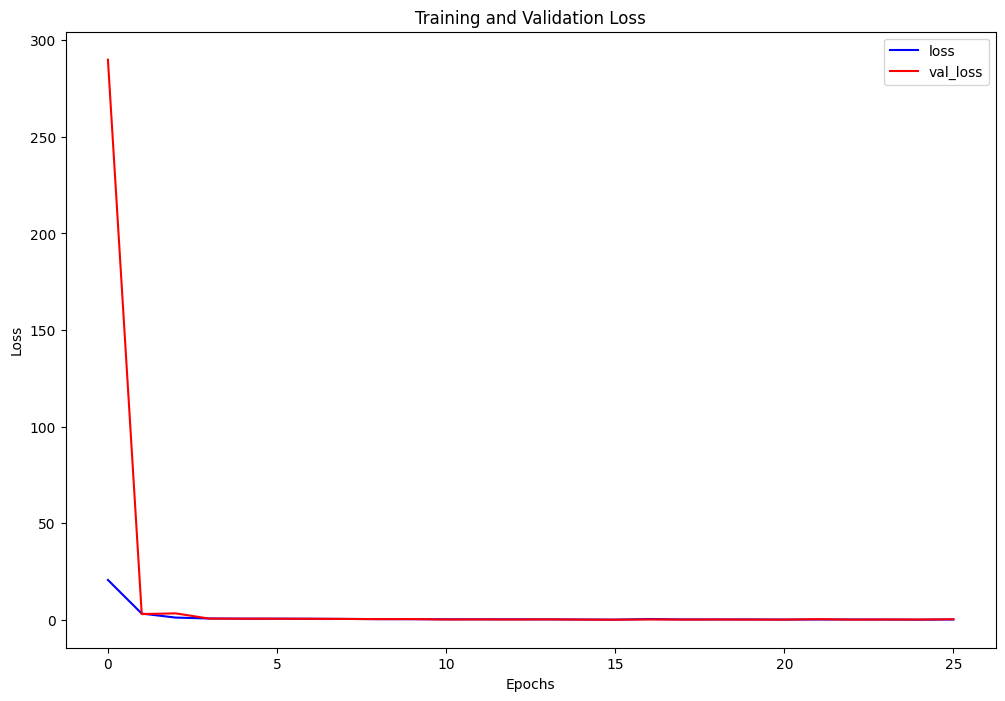

In [17]:
# Plot train and validation loss
plt.figure(figsize=(12, 8))
sns.lineplot(data=history_df.loc[:, ["loss", "val_loss"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

In [22]:
# Evaluate the model on the test data
loss, accuracy, _ = model.evaluate([X_tab_test, X_img_test], y_test)

# Print the overall accuracy
print("Overall Accuracy:", accuracy)


7/7 [==============================] - 0s 30ms/step - loss: 0.1267 - accuracy: 0.9621 - F1_score: 0.8239
Overall Accuracy: 0.9620853066444397


In [18]:
# Classification report
y_pred = model.predict([X_tab_test, X_img_test])
y_pred_classes = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))


7/7 [==============================] - 2s 19ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.94        60
           1       0.99      0.95      0.97       151

    accuracy                           0.96       211
   macro avg       0.94      0.97      0.95       211
weighted avg       0.96      0.96      0.96       211



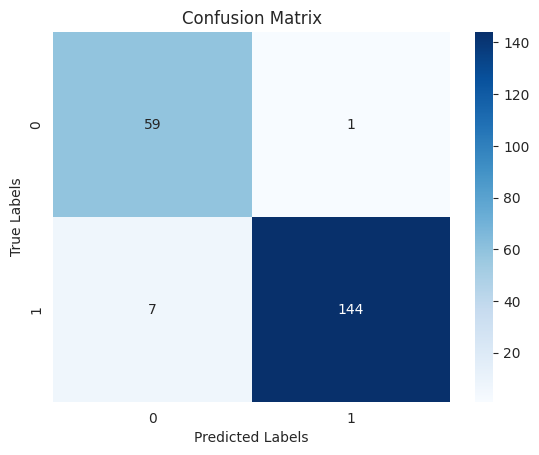

In [19]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [21]:
# Save the model
model.save('/content/toddler_autism_model.h5')
print("Model saved successfully!")


Model saved successfully!


Saving 6.jpg to 6 (1).jpg
1/1 [==============================] - 0s 19ms/step


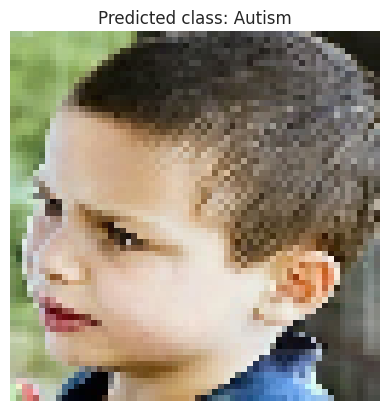

In [30]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the tabular data (replace with your actual tabular data)
# For example, if you want to use validation data for predictions
tabular_data = X_tab_val

# Ensure that the number of samples in tabular data matches the number of images
tabular_data = tabular_data[:len(img)]

# Upload an image file
uploaded = files.upload()

# Get the file name
file_name = next(iter(uploaded))

# Read and resize the uploaded image
img = cv2.imdecode(np.frombuffer(uploaded[file_name], np.uint8), -1)
img = cv2.resize(img, (img_height, img_width))
img = np.expand_dims(img, axis=0)  # Add batch dimension

# Make predictions
predictions = model.predict([tabular_data, img])
class_index = np.argmax(predictions)

# Print the predicted class
if class_index == 1:
    predicted_class = "Autism"
else:
    predicted_class = "No Autism"

# Display the image
plt.imshow(cv2.cvtColor(img[0], cv2.COLOR_BGR2RGB))
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()
